## Initialisation: Installation des modules requis

In [4]:
import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install librosa
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install h5py
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install pydub
# installer libav ou ffmpeg

In [1]:
from pydub import AudioSegment
import os
import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.layers import Convolution1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt

C:\Users\Max\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Etape 1: Découpage de l'audio

### Définition des fonctions de découpe et de sauvegarde

In [2]:
# Découpe la base de données originale selon les moments bee ou nobee
original_sound_datasetpath = "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/OriginalTestDataset/Sound"
original_lab_datasetpath = "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/OriginalTestDataset/.lab"
fulldatasetpath = "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset"

# Enregistre l'audio


def save_audio(newAudio, audio_file_name, condition, j, k=None):
    if 'Missing Queen' in audio_file_name or 'NO_QueenBee' in audio_file_name:
        if condition == "bee\n":
            newAudio.export(str(fulldatasetpath + '/' + 'missing queen'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
    elif 'NO_QueenBee' not in audio_file_name and 'QueenBee' in audio_file_name:
        if condition == "bee\n":
            newAudio.export(str(fulldatasetpath + '/' + 'queen bee'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
    else:
        if condition == "bee\n":
            newAudio.export(str(fulldatasetpath + '/' + 'bee'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")


def save_audio_mix(newAudio, audio_file_name, condition, j, k):
    if 'Missing Queen' in audio_file_name or 'NO_QueenBee' in audio_file_name:
        if (condition == "bee\n" and k < 3 ) or (condition == "nobee\n" and k > 1):
            newAudio.export(str(fulldatasetpath + '/' + 'missing queen'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
    elif 'NO_QueenBee' not in audio_file_name and 'QueenBee' in audio_file_name:
        if (condition == "bee\n" and k < 3) or (condition == "nobee\n" and k > 1):
            newAudio.export(str(fulldatasetpath + '/' + 'queen bee'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
    else:
        if (condition == "bee\n" and k < 3) or (condition == "nobee\n" and k > 1):
            newAudio.export(str(fulldatasetpath + '/' + 'bee'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")

# Découpe le fichier .wav associé au fichier.lab dont l'adresse est mise en entrée selon les moments bee ou nobee


def file_split(adresse_lab):
    # obtenir le nom et l'adresse du fichier audio associé
    text = open(adresse_lab, mode="r").readlines()
    del text[-1]  # On enlève le point final
    text[0] = text[0].rstrip()
    audio_file_name = text[0]
    audio_file_path = str(original_sound_datasetpath + '/' + audio_file_name + '.wav')
    # Reccueillir les temps des extraits
    n = len(text)
    for j in range(1, n):
        text[j] = text[j].split('\t')
        text[j][0] = float(text[j][0])
        text[j][1] = float(text[j][1])
    # On découpe et on enregistre les extraits

    for j in range(1, n):
        t1 = text[j][0] * 1000  # Works in milliseconds
        t2 = text[j][1] * 1000
        # Ici, on effectue des enregistrements d'une durée constante (condition nécessaire pour le réseau de neurones)
        if t2-t1 >= 4000:
            k = 0
            while t1 + 4000 <= t2:
                newAudio = AudioSegment.from_wav(audio_file_path)
                newAudio = newAudio[t1:t1+4000]
                save_audio(newAudio, audio_file_name, text[j][2], j, k)
                t1 += 3600  # Avec recouvrement
                k += 1
                print(audio_file_name, k)


def file_split_mix(adresse_lab):
    # obtenir le nom et l'adresse du fichier audio associé
    text = open(adresse_lab, mode="r").readlines()
    del text[-1]  # On enlève le point final
    text[0] = text[0].rstrip()
    audio_file_name = text[0]
    audio_file_path = str(original_sound_datasetpath + '/' + audio_file_name + '.wav')
    # Reccueillir les temps des extraits
    n = len(text)
    for j in range(1, n):
        text[j] = text[j].split('\t')
        text[j][0] = float(text[j][0])
        text[j][1] = float(text[j][1])
    # On découpe et on enregistre les extraits

    for j in range(1, n-1):
        t1 = text[j][0] * 1000  # Works in milliseconds
        t2 = text[j][1] * 1000
        t3 = text[j+1][1] * 1000
        if t3-t2 >= 3000 and t2-t1 >= 3000:
            k=3
            newAudio = AudioSegment.from_wav(audio_file_path)
            newAudio = newAudio[t2-(4-k)*1000:t2+k*1000]
            save_audio_mix(newAudio, audio_file_name, text[j][2], j, k)

### Découpage de la base de donnée audio

In [11]:
# Découpage de la base de donnée originale
liste_adresses_fichiers_lab = glob.glob(original_lab_datasetpath+"/*")
start = datetime.now()
for adresse_fichier in liste_adresses_fichiers_lab:
    file_split(adresse_fichier)
duration = datetime.now() - start
print("Finished slicing in time: ", duration)

346106__strangeacoustics__palm-trees-in-the-wind 1
346106__strangeacoustics__palm-trees-in-the-wind 2
346106__strangeacoustics__palm-trees-in-the-wind 3
346106__strangeacoustics__palm-trees-in-the-wind 4
346106__strangeacoustics__palm-trees-in-the-wind 5
346106__strangeacoustics__palm-trees-in-the-wind 6
346106__strangeacoustics__palm-trees-in-the-wind 7
346106__strangeacoustics__palm-trees-in-the-wind 8
346106__strangeacoustics__palm-trees-in-the-wind 9
346106__strangeacoustics__palm-trees-in-the-wind 10
346106__strangeacoustics__palm-trees-in-the-wind 11
346106__strangeacoustics__palm-trees-in-the-wind 12
346106__strangeacoustics__palm-trees-in-the-wind 13
346106__strangeacoustics__palm-trees-in-the-wind 14
346106__strangeacoustics__palm-trees-in-the-wind 15
346106__strangeacoustics__palm-trees-in-the-wind 16
346106__strangeacoustics__palm-trees-in-the-wind 17
346106__strangeacoustics__palm-trees-in-the-wind 18
346106__strangeacoustics__palm-trees-in-the-wind 19
346106__strangeacoust

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable

## Etape 2: Création du fichier csv

### Définition des fonctions nécessaires

In [3]:
# donne les informations à rentrer dans le fichier csv pour tous les fichiers contenus dans le dossier folder

def informations(folder):
    informations = []
    liste_adresses_fichiers = glob.glob(
        "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset/"+str(folder)+"/*")  # changer éventuellement le chemin à la BDD
    if folder == 'bee':  
        classID = '1'
        class_name = 'bee'
    elif folder == 'nobee':
        classID = '0'
        class_name = 'nobee'
    elif folder == 'missing queen':
        classID = '2'
        class_name = 'missing queen'
    elif folder == 'queen bee':
        classID = '3'
        class_name = 'queen bee'
    for adresse_fichier in liste_adresses_fichiers:
        file_name = os.path.basename(adresse_fichier)
        fold = str(folder)
        informations.append([file_name, fold, classID, class_name])
    return(informations)

# Crée le fichier csv contenant les infos sur tous les fichiers .wav

def CSV_maker():
    entetes = [
        u'slice_file_name',
        u'fold',
        u'classID',
        u'class_name'
    ]

    valeurs = [information for information in informations('bee')] + [information for information in informations('nobee')]+[information for information in informations('missing queen')]+[information for information in informations('queen bee')]
   
    f = open('BeeSound.csv', 'w')
    ligneEntete = ",".join(entetes) + "\n"
    f.write(ligneEntete)
    for valeur in valeurs:
        ligne = ",".join(valeur) + "\n"
        f.write(ligne)

    f.close()

### Création du fichier CSV

In [4]:
CSV_maker()

## Etape 3: Extraction des caractéristiques des signaux sonores

### Définition de la fonction extrayant les coefficients cepstraux des signaux sonores

In [5]:
# Extracting MFCC's for every file

def extract_features(file_name):

    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T, axis=0)
        norm = np.linalg.norm(mfccsscaled)
        normal_array = mfccsscaled/norm
    except Exception:
        print("Error encountered while parsing file: ", file_name)
        return None

    return normal_array

### Extraction des caractéristiques et sauvegarde de l'encodage des labels

In [6]:
# Set the path to the full dataset
fulldatasetpath = "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset"
# Set the path to the csv file
metadata = pd.read_csv(
    "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/BeeSound.csv") 
features = []
start0 = datetime.now()
# Iterate through each sound file and extract the features
for index, row in metadata.iterrows():

    file_name = os.path.join(
        fulldatasetpath, str(row["fold"]), str(row["slice_file_name"]))
    print(file_name)
    class_label = row["class_name"]
    data = extract_features(file_name)

    features.append([data, class_label])
# Convert into a Panda dataframe
featuresdf = pd.DataFrame(features, columns=['feature', 'class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')
duration0 = datetime.now() - start0
print("Finished feature extraction in time: ", duration0)

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

# split the dataset
x_train, x_test, y_train, y_test = train_test_split(
    X, yy, test_size=0.3, random_state=42)
x_val, x_test,  y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.6, random_state=42)  # laisser le shuffle

### store the label encoder for future predictions
%store le

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n1_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day -

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n13_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n13_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n13_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n13_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n13_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n13_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Da

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n19_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n1_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n21_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n23_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n23_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n25_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n25_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n25_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n25_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\131032__klankbeeld__wind-in-tree-white-birch-01_n1_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\131032__klankbeeld__wind-in-tree-white-birch-01_n1_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\131032__klankbeeld__wind-in-tree-white-birch-01_n1_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\131032__klankbeeld__wind-in-tree-white-birch-01_n1_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\131032__klankbeeld__wind-in-tree-white-birch-01_n1_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\131032__klankbeeld__wind-in-tree-white-birch-01_n1_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\131032__klankbeeld__wind-in-tree-white-birch-01_n1_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\131032__klankbeeld__wind-in-tree-white-birch-01_n1_4.wav
C:/Users/Max/Docu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn__the-wind-in-the-trees_n1_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\234914__tim-kahn

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_36.wav
C:/Users/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_94.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_95.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_96.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_97.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_98.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\346106__strangeacoustics__palm-trees-in-the-wind_n1_99.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n40_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n40_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n48_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n50_0.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n10_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n10_1.wav
C:/Users/Max/Documents/CS/Travail/FIBE

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n42_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n4_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n6_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n8_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n8_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_2.wav
C:/Users/Max/Documents/CS/Travail/FI

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n14_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n26_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n28_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n2_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n32_0.wav
C:/Users/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n82_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n8_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n100_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n104_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n10_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n10_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n112_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n114_0.wav
C:/Us

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n32_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n34_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n34_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n34_2.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n22_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n22_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n22_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_4.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n10_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n16_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n16_1.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n14_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n16_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n18_0.wav
C:/Users/Max/Documents/CS/Travai

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_9.wav
C:/Users/Max/Documents/CS/Travai

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n35_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n37_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n39_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n3_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n3_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n41_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n43_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n77_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n79_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n79_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n81_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n81_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n83_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n83_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n17_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n43_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n43_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n47_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n49_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n49_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n55_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n59_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n55_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n57_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n61_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n61_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n65_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n67_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n67_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hi

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n3_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hi

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n5_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n5_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_0

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n13_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n13_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n15_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n15_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n17_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n17_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n3_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n3_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n3_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n25_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n27_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n27_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n17_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n17_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n19_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_4.wav
C:/Us

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n5_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n5_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n7_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n7_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n7_2.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_9.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n3_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n3_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n5_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n5_1.wav
C:/U

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n35_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n35_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n35_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n35_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n35_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n35_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n37_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n37_1.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n23_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n23_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n25_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n27_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n27_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n37_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n39_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n39_1.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_1.wav
C:/Use

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_8.w

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n7_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n7_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n9_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n9_1.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n27_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n27_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n3_0.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n27_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n27_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n27_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n27_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n29_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n29_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n29_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n31_0.wav


## Etape 4 : Entrainement, validation et test automatique du réseau de neurones

### Adaptation pour la structure du CNN

In [7]:
num_labels = yy.shape[1]
filter_size = 2
num_rows = 40
num_channels = 1
x_train = x_train.reshape(x_train.shape[0], num_rows, num_channels)
x_val = x_val.reshape(x_val.shape[0], num_rows, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_channels)

### Construction du réseau de neurones

In [8]:
# Construct the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=10,
                 input_shape=(num_rows, num_channels, ), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

#model.add(Conv1D(filters=32, kernel_size=10, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling1D())

model.add(Dense(num_labels, activation='softmax'))

#model = Sequential()

#model.add(Dense(80, input_shape=(40,)))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))

# model.add(Dense(80))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))

# model.add(Dense(num_labels))
# model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')

# Display model architecture summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 31, 32)            352       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 64)             20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0

### Entraînement et validation du réseau de neurones

Epoch 1/1000
51/51 [==============================] - 4s 57ms/step - loss: 1.3283 - accuracy: 0.4061 - val_loss: 1.3106 - val_accuracy: 0.3902
Epoch 2/1000
51/51 [==============================] - 0s 8ms/step - loss: 1.2699 - accuracy: 0.4152 - val_loss: 1.3057 - val_accuracy: 0.3902
Epoch 3/1000
51/51 [==============================] - 0s 8ms/step - loss: 1.2664 - accuracy: 0.4023 - val_loss: 1.2993 - val_accuracy: 0.3902
Epoch 4/1000
51/51 [==============================] - 0s 8ms/step - loss: 1.2592 - accuracy: 0.4146 - val_loss: 1.2878 - val_accuracy: 0.3902
Epoch 5/1000
51/51 [==============================] - 0s 8ms/step - loss: 1.2531 - accuracy: 0.4118 - val_loss: 1.2761 - val_accuracy: 0.3902
Epoch 6/1000
51/51 [==============================] - 0s 8ms/step - loss: 1.2346 - accuracy: 0.4046 - val_loss: 1.2429 - val_accuracy: 0.3949
Epoch 7/1000
51/51 [==============================] - 0s 8ms/step - loss: 1.2208 - accuracy: 0.4183 - val_loss: 1.1993 - val_accuracy: 0.4299
Epoch

Epoch 115/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.4192 - accuracy: 0.8328 - val_loss: 0.3765 - val_accuracy: 0.8575
Epoch 116/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.4588 - accuracy: 0.8034 - val_loss: 0.3688 - val_accuracy: 0.8481
Epoch 117/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.4719 - accuracy: 0.7952 - val_loss: 0.3820 - val_accuracy: 0.8505
Epoch 118/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.4568 - accuracy: 0.8107 - val_loss: 0.3631 - val_accuracy: 0.8575
Epoch 119/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.4340 - accuracy: 0.8212 - val_loss: 0.3604 - val_accuracy: 0.8458
Epoch 120/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.4447 - accuracy: 0.8255 - val_loss: 0.3584 - val_accuracy: 0.8505
Epoch 121/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.4608 - accuracy: 0.8040 - val_loss: 0.3585 - val_accuracy:

Epoch 172/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3966 - accuracy: 0.8404 - val_loss: 0.3386 - val_accuracy: 0.8598
Epoch 173/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.4447 - accuracy: 0.8069 - val_loss: 0.3290 - val_accuracy: 0.8621
Epoch 174/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.4242 - accuracy: 0.8294 - val_loss: 0.3281 - val_accuracy: 0.8621
Epoch 175/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3834 - accuracy: 0.8432 - val_loss: 0.3334 - val_accuracy: 0.8621
Epoch 176/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3962 - accuracy: 0.8340 - val_loss: 0.3259 - val_accuracy: 0.8621
Epoch 177/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3858 - accuracy: 0.8478 - val_loss: 0.3278 - val_accuracy: 0.8621
Epoch 178/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3920 - accuracy: 0.8377 - val_loss: 0.3250 - val_accuracy:

Epoch 229/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.3625 - accuracy: 0.8458 - val_loss: 0.3208 - val_accuracy: 0.8715
Epoch 230/1000
51/51 [==============================] - 0s 10ms/step - loss: 0.3734 - accuracy: 0.8427 - val_loss: 0.3119 - val_accuracy: 0.8692
Epoch 231/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3564 - accuracy: 0.8612 - val_loss: 0.3219 - val_accuracy: 0.8692
Epoch 232/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3564 - accuracy: 0.8513 - val_loss: 0.3094 - val_accuracy: 0.8738
Epoch 233/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3355 - accuracy: 0.8657 - val_loss: 0.3071 - val_accuracy: 0.8738
Epoch 234/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3572 - accuracy: 0.8523 - val_loss: 0.3161 - val_accuracy: 0.8715
Epoch 235/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3661 - accuracy: 0.8454 - val_loss: 0.3090 - val_accuracy

Epoch 286/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3413 - accuracy: 0.8605 - val_loss: 0.3019 - val_accuracy: 0.8692
Epoch 287/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3634 - accuracy: 0.8490 - val_loss: 0.2960 - val_accuracy: 0.8738
Epoch 288/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3403 - accuracy: 0.8607 - val_loss: 0.2984 - val_accuracy: 0.8808
Epoch 289/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3699 - accuracy: 0.8476 - val_loss: 0.2966 - val_accuracy: 0.8832
Epoch 290/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3371 - accuracy: 0.8650 - val_loss: 0.2977 - val_accuracy: 0.8762
Epoch 291/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3506 - accuracy: 0.8629 - val_loss: 0.3085 - val_accuracy: 0.8762
Epoch 292/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3394 - accuracy: 0.8601 - val_loss: 0.2953 - val_accuracy:

Epoch 343/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3237 - accuracy: 0.8666 - val_loss: 0.2959 - val_accuracy: 0.8808
Epoch 344/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3182 - accuracy: 0.8726 - val_loss: 0.2842 - val_accuracy: 0.8879
Epoch 345/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3196 - accuracy: 0.8726 - val_loss: 0.3005 - val_accuracy: 0.8715
Epoch 346/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3172 - accuracy: 0.8737 - val_loss: 0.2920 - val_accuracy: 0.8832
Epoch 347/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3224 - accuracy: 0.8718 - val_loss: 0.2902 - val_accuracy: 0.8762
Epoch 348/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.3497 - accuracy: 0.8595 - val_loss: 0.3003 - val_accuracy: 0.8785
Epoch 349/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.3216 - accuracy: 0.8727 - val_loss: 0.2931 - val_accuracy:

Epoch 400/1000
51/51 [==============================] - 1s 11ms/step - loss: 0.3215 - accuracy: 0.8660 - val_loss: 0.2827 - val_accuracy: 0.8692
Epoch 401/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.3047 - accuracy: 0.8750 - val_loss: 0.2821 - val_accuracy: 0.8668
Epoch 402/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3080 - accuracy: 0.8661 - val_loss: 0.2899 - val_accuracy: 0.8832
Epoch 403/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3143 - accuracy: 0.8622 - val_loss: 0.2802 - val_accuracy: 0.8785
Epoch 404/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3145 - accuracy: 0.8700 - val_loss: 0.2831 - val_accuracy: 0.8808
Epoch 405/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3202 - accuracy: 0.8669 - val_loss: 0.2855 - val_accuracy: 0.8715
Epoch 406/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3240 - accuracy: 0.8614 - val_loss: 0.2817 - val_accuracy

Epoch 457/1000
51/51 [==============================] - 1s 10ms/step - loss: 0.3231 - accuracy: 0.8637 - val_loss: 0.2681 - val_accuracy: 0.8832
Epoch 458/1000
51/51 [==============================] - 1s 10ms/step - loss: 0.3515 - accuracy: 0.8401 - val_loss: 0.2815 - val_accuracy: 0.8785
Epoch 459/1000
51/51 [==============================] - 1s 10ms/step - loss: 0.3259 - accuracy: 0.8661 - val_loss: 0.2721 - val_accuracy: 0.8855
Epoch 460/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.2962 - accuracy: 0.8802 - val_loss: 0.2711 - val_accuracy: 0.8785
Epoch 461/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.3154 - accuracy: 0.8695 - val_loss: 0.2855 - val_accuracy: 0.8621
Epoch 462/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3170 - accuracy: 0.8677 - val_loss: 0.2721 - val_accuracy: 0.8832
Epoch 463/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.3391 - accuracy: 0.8559 - val_loss: 0.2832 - val_accura

Epoch 570/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3089 - accuracy: 0.8665 - val_loss: 0.2637 - val_accuracy: 0.8832
Epoch 571/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2980 - accuracy: 0.8742 - val_loss: 0.2636 - val_accuracy: 0.8925
Epoch 572/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.2918 - accuracy: 0.8818 - val_loss: 0.2628 - val_accuracy: 0.8925
Epoch 573/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.2844 - accuracy: 0.8813 - val_loss: 0.2630 - val_accuracy: 0.8925
Epoch 574/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.3104 - accuracy: 0.8695 - val_loss: 0.2665 - val_accuracy: 0.8879
Epoch 575/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.2877 - accuracy: 0.8882 - val_loss: 0.2674 - val_accuracy: 0.8762
Epoch 576/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.3166 - accuracy: 0.8740 - val_loss: 0.2600 - val_accuracy:

Epoch 627/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2865 - accuracy: 0.8865 - val_loss: 0.2554 - val_accuracy: 0.8855
Epoch 628/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3120 - accuracy: 0.8752 - val_loss: 0.2563 - val_accuracy: 0.8925
Epoch 629/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.2900 - accuracy: 0.8819 - val_loss: 0.2688 - val_accuracy: 0.8785
Epoch 630/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.2944 - accuracy: 0.8783 - val_loss: 0.2571 - val_accuracy: 0.8785
Epoch 631/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3117 - accuracy: 0.8701 - val_loss: 0.2552 - val_accuracy: 0.8949
Epoch 632/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.2923 - accuracy: 0.8755 - val_loss: 0.2548 - val_accuracy: 0.8832
Epoch 633/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2994 - accuracy: 0.8786 - val_loss: 0.2618 - val_accuracy:

Epoch 740/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2693 - accuracy: 0.8939 - val_loss: 0.2616 - val_accuracy: 0.8715
Epoch 741/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2717 - accuracy: 0.8836 - val_loss: 0.2477 - val_accuracy: 0.8808
Epoch 742/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.2508 - accuracy: 0.8990 - val_loss: 0.2504 - val_accuracy: 0.8808
Epoch 743/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.2900 - accuracy: 0.8824 - val_loss: 0.2473 - val_accuracy: 0.8808
Epoch 744/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2738 - accuracy: 0.8793 - val_loss: 0.2426 - val_accuracy: 0.8808
Epoch 745/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2704 - accuracy: 0.8949 - val_loss: 0.2505 - val_accuracy: 0.8808
Epoch 746/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2892 - accuracy: 0.8732 - val_loss: 0.2492 - val_accuracy:

Epoch 853/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.2624 - accuracy: 0.8935 - val_loss: 0.2447 - val_accuracy: 0.8832
Epoch 854/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2735 - accuracy: 0.8889 - val_loss: 0.2468 - val_accuracy: 0.8808
Epoch 855/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.2638 - accuracy: 0.8882 - val_loss: 0.2447 - val_accuracy: 0.8832
Epoch 856/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.2490 - accuracy: 0.8963 - val_loss: 0.2391 - val_accuracy: 0.8995
Epoch 857/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.2677 - accuracy: 0.8900 - val_loss: 0.2359 - val_accuracy: 0.8902
Epoch 858/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.2437 - accuracy: 0.8955 - val_loss: 0.2376 - val_accuracy: 0.8902
Epoch 859/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2923 - accuracy: 0.8730 - val_loss: 0.2380 - val_accuracy:

Epoch 910/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2497 - accuracy: 0.9002 - val_loss: 0.2368 - val_accuracy: 0.8879
Epoch 911/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2581 - accuracy: 0.8976 - val_loss: 0.2518 - val_accuracy: 0.8785
Epoch 912/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2573 - accuracy: 0.8943 - val_loss: 0.2374 - val_accuracy: 0.8879
Epoch 913/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2601 - accuracy: 0.8901 - val_loss: 0.2421 - val_accuracy: 0.8902
Epoch 914/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2825 - accuracy: 0.8725 - val_loss: 0.2390 - val_accuracy: 0.8925
Epoch 915/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2693 - accuracy: 0.8887 - val_loss: 0.2406 - val_accuracy: 0.8879
Epoch 916/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2653 - accuracy: 0.8846 - val_loss: 0.2340 - val_accuracy:

Epoch 967/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2917 - accuracy: 0.8826 - val_loss: 0.2381 - val_accuracy: 0.8808
Epoch 968/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2466 - accuracy: 0.9003 - val_loss: 0.2387 - val_accuracy: 0.8902
Epoch 969/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2434 - accuracy: 0.9090 - val_loss: 0.2379 - val_accuracy: 0.8879
Epoch 970/1000
51/51 [==============================] - 0s 9ms/step - loss: 0.2461 - accuracy: 0.8947 - val_loss: 0.2387 - val_accuracy: 0.9042
Epoch 971/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.2574 - accuracy: 0.8966 - val_loss: 0.2324 - val_accuracy: 0.8995
Epoch 972/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.2390 - accuracy: 0.9136 - val_loss: 0.2303 - val_accuracy: 0.8902
Epoch 973/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.2695 - accuracy: 0.8855 - val_loss: 0.2404 - val_accuracy:

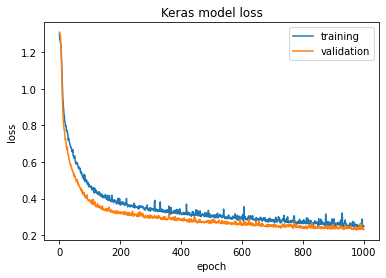

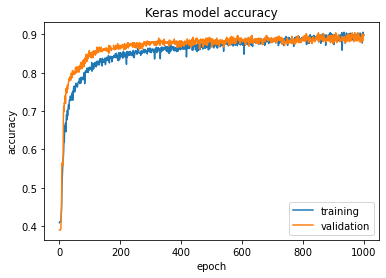

Training completed in time:  0:06:57.978816
Training Accuracy:  0.9196321368217468
Validation Accuracy:  0.8971962332725525


In [9]:
# Training the model

num_epochs = 1000
num_batch_size = 50
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(x_val, y_val), callbacks=None, verbose=1)
# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

duration = datetime.now() - start
print("Training completed in time: ", duration)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_val, y_val, verbose=0)
print("Validation Accuracy: ", score[1])

### Obtention de la matrice de confusion

In [10]:
# Confusion matrix
X_pred = model.predict(x_test)
y_pred = []
for predicted_proba_vector in X_pred:
    maxi = np.argmax(predicted_proba_vector)
    prediction = le.inverse_transform([maxi])
    y_pred.append(prediction)
y_true = []
for vector in y_test:
    maxi = np.argmax(vector)
    cat = le.inverse_transform([maxi])
    y_true.append(cat)
M = metrics.confusion_matrix(
    y_true, y_pred, labels=['bee', 'queen bee', 'missing queen', 'nobee'],  normalize='true')
print(M)

[[1.         0.         0.         0.        ]
 [0.         0.95488722 0.         0.04511278]
 [0.         0.         0.97083333 0.02916667]
 [0.         0.08333333 0.21875    0.69791667]]


### Sauvegarde du modèle

In [11]:
# Saving the model
model.save('bee_sound_model.h5')

## Etape 5: Prédictions

### Chargement de l'encodage des labels et du modèle

In [12]:
%store -r le
# Loading the model
loaded_model = tf.keras.models.load_model('bee_sound_model.h5')

In [13]:
def return_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    x_test = prediction_feature.reshape(1, num_rows, num_channels)
    X_pred = loaded_model.predict(x_test)
    for predicted_proba_vector in X_pred:
        maxi = np.argmax(predicted_proba_vector)
        prediction = le.inverse_transform([maxi])
        return(prediction[0])

In [14]:
test_dataset_path="C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/TestDataset/missing queen"
liste_adresses_fichiers = glob.glob(test_dataset_path+"/*")
missing_queen=0
nobee=0
for adresse_fichier in liste_adresses_fichiers:
    print(return_prediction(adresse_fichier))
    if 'missing' in str(return_prediction(adresse_fichier)) : 
            missing_queen+=1
    else:
            nobee+=1
print("missing queen", missing_queen)
print("nobee", nobee)

missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
nobee
nobee
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
nobee
nobee
nobee
missing queen
missing queen
missing queen
nobee
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
nobee
nobee
missing queen
missing queen
missing queen
nobee
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing queen
missing 